# Initialization

In [1]:
#!/usr/bin/python

__author__ = 'Elliot Simon'
__email__ = 'ellsim@dtu.dk'
__date__ = 'May 9, 2018'
__credits__ = ["DTU-Risø", "NCAR"]

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import datetime
import scipy
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics, preprocessing
import keras
import tensorflow as tf

In [2]:
from keras.models import Model, save_model, load_model, Sequential
from keras.layers import Reshape, Dense, Activation, Conv2D, Input, AveragePooling2D, MaxPooling2D, MaxPooling3D, Flatten, TimeDistributed, LSTM
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers import Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
import keras.backend as K
from keras.callbacks import EarlyStopping

In [3]:
print(keras.__version__)
print(tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.2.2
1.10.0
Found GPU at: /device:GPU:0


In [4]:
%matplotlib inline

In [5]:
plt.style.use('classic')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Serif'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['savefig.transparent'] = True

In [9]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmptg3cl9zt/pubring.gpg' created
gpg: /tmp/tmptg3cl9zt/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [10]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


# Process input data

## X-data

### Optical flow (X)

In [7]:
%%time
# Load in optical flow result from other notebook
X_input_data = np.load('flows.npy')
print(X_input_data.shape)

(201, 394, 2, 3270)
CPU times: user 12 ms, sys: 2.96 s, total: 2.97 s
Wall time: 32.9 s


In [8]:
# Reshape to correct input (Time, Y, X, C-features)
X_input_data = np.moveaxis(X_input_data, -1, 0)
X_input_shape = X_input_data.shape
print(X_input_shape)

(3270, 201, 394, 2)


### Radial speeds (X)

In [9]:
!ls

Check GPU Support.ipynb     LASCAR_NN_Collab.ipynb
df_joined_13s_Nov14_15.hdf  LASCAR Optical Flow CNN.ipynb
flows.npy		    Nov14-15_cart_scans.npy


In [7]:
# Load in cartesian transformed lidar scans from other notebook
X_input_data = np.load('Nov14-15_cart_scans.npy')
print(X_input_data.shape)

(201, 394, 3270)


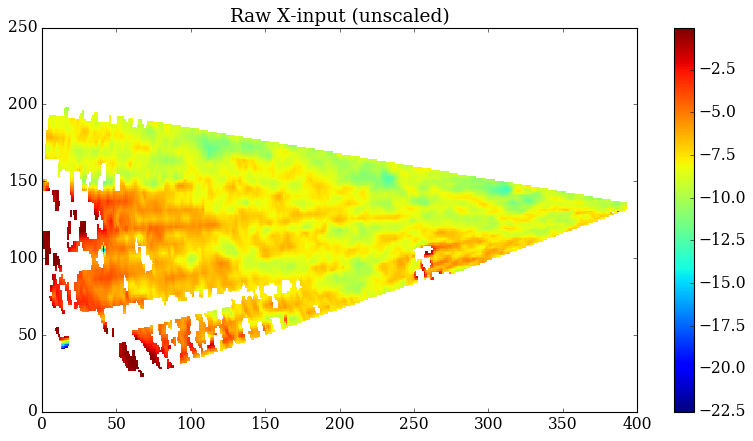

In [8]:
# Plot one to check
plt.pcolormesh(X_input_data[:,:,0])
plt.colorbar()
plt.title('Raw X-input (unscaled)');

In [0]:
# Absolute value everything to make speeds positive?
#X_input_data = np.abs(X_input_data)

In [9]:
# Reshape to correct input (Time, Y, X, C-features)
# Last axis is added even though only 1 channel exists
X_input_data = np.moveaxis(X_input_data, -1, 0)
X_input_data = X_input_data[:,:,:,np.newaxis]

#X_input_data = X_input_data.reshape(X_input_data.shape[0], X_input_data.shape[1], X_input_data.shape[2], 1)
X_input_shape = X_input_data.shape
print(X_input_shape)

(3270, 201, 394, 1)


### Lidar Reconstructed Speeds (X)

In [0]:
#X_input_data = df_13s.iloc[:,15:212]
#print(X_input_data.shape)

# y-Data

### Mast data u&v (y)

In [0]:
# Make some random Y data for initial testing 
#y_input_data = np.random.weibull(7, size=(X_input_shape[0],1))
#print(y_input_data.shape)

In [0]:
# Load mast data and already calculated u,v
# Has been resampled from 50Hz to 1s already
#starttime = '201711141400'
#endtime = '201711150200'
#filename = starttime + "_" + endtime

#df_mast_1s = pd.read_hdf(filename + '_1s.hd5','df')

In [0]:
# Timestamps already accounted for when prepping data
# Shift timestamp to match windscanner
# 60 minutes for UTC-CET conversion, and 10 minutes to stamping notation
#df_mast_1s = df_mast_1s.shift(freq=pd.Timedelta(minutes=-70))

In [0]:
# Resample to 13 second periods
#print(df_mast_1s.shape[0]/13)
#df_mast_13s = df_mast_1s.resample('13S').mean()
#df_mast_13s = df_mast_1s.rolling('13S').mean()
#print(df_mast_13s.shape[0])

In [10]:
# Read in already prepared mast-dataset, including already decomposed u & v
df_13s = pd.read_hdf('df_joined_13s_Nov14_15.hdf','df')
print(df_13s.shape)
# Remove last value to match lidar input shape
df_13s = df_13s.iloc[0:-1]
print(df_13s.shape)

(3271, 409)
(3270, 409)


In [11]:
# See what kind of data we have from the mast & turbine
df_13s.columns[0:15]

Index(['ROT', 'pitch', 'ActPow', 'SWsp_70m', 'Sdir_70m', 'SWsp_44m',
       'Sdir_44m', 'SWsp_18m', 'Sdir_18m', 'u_70m', 'u_44m', 'u_18m', 'v_70m',
       'v_44m', 'v_18m'],
      dtype='object')

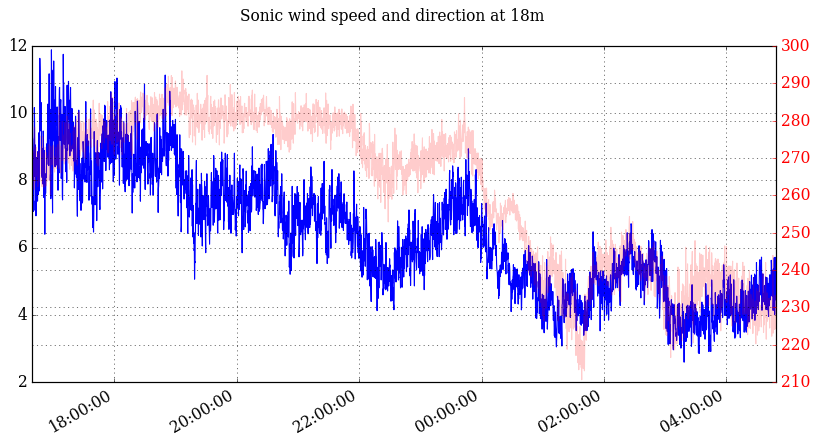

In [12]:
f = plt.figure()
ax = df_13s['SWsp_18m'].plot()
ax2 = ax.twinx()
df_13s['Sdir_18m'].plot(ax=ax2, c='r', alpha=0.2)
ax2.tick_params('y', colors='r')
plt.suptitle('Sonic wind speed and direction at 18m');

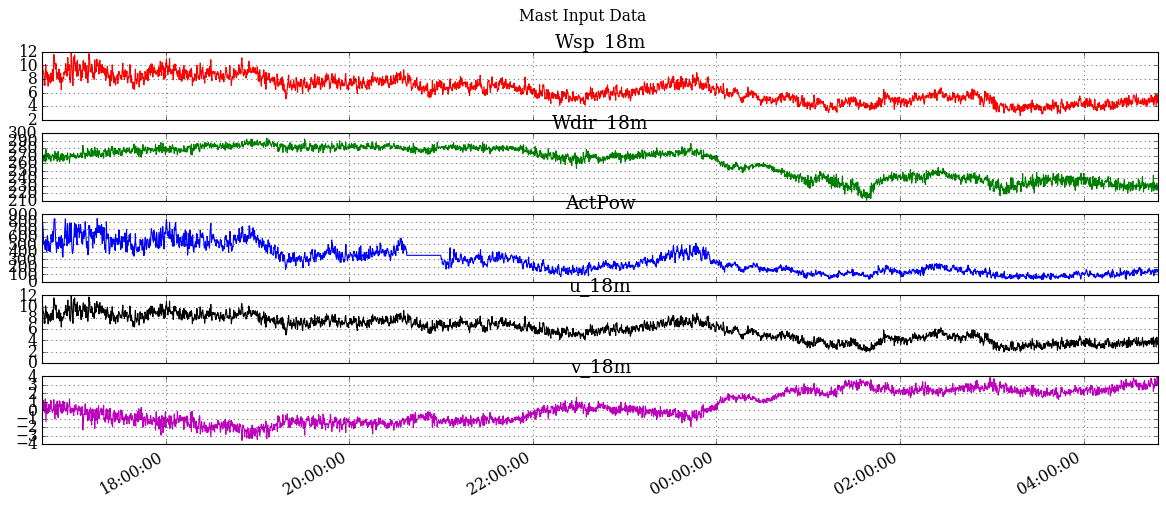

In [13]:
# Inspect time series
f, axarr = plt.subplots(5,1, figsize=(18,7))
axarr[0].plot(df_13s['SWsp_18m'], c='r')
axarr[1].plot(df_13s['Sdir_18m'], c='g')
axarr[2].plot(df_13s['ActPow'], c='b')
axarr[3].plot(df_13s['u_18m'], c='k')
axarr[4].plot(df_13s['v_18m'], c='m')


plt.suptitle('Mast Input Data', fontsize=14)
axarr[0].set_title('Wsp_18m')
axarr[1].set_title('Wdir_18m')
axarr[2].set_title('ActPow')
axarr[3].set_title('u_18m')
axarr[4].set_title('v_18m')
f.autofmt_xdate()

In [14]:
# Format our Y input from the mast data
# 2D, u & v horizontal components
y_input_data = np.vstack([df_13s['u_18m'], df_13s['v_18m']])
y_input_data = np.moveaxis(y_input_data, -1, 0)

print(y_input_data.shape)

(3270, 2)


In [0]:
# Format our Y input from the mast data
# 1D, Sonic wind speed 18m
#y_input_data = df_13s['SWsp_18m']
#print(y_input_data.shape)

### Brise DBS (y)

In [0]:
# To do

## More pre-processing and checks

# Train/test split

In [0]:
# Sub-select just a small test dataset
X_small = X_input_data[0:2500,:,:,:]
y_small = y_input_data[0:2500,:]

In [15]:
%%time
# Split up train/test data by breakpoint
X_train, X_test, y_train, y_test = train_test_split(X_input_data, y_input_data, test_size=0.33, random_state=42, shuffle=False)
#X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.33, random_state=42, shuffle=False)

CPU times: user 9.36 s, sys: 2.48 s, total: 11.8 s
Wall time: 11.8 s


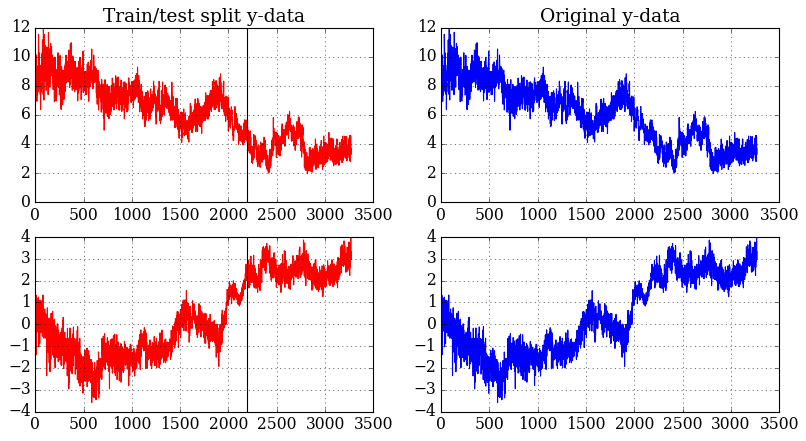

In [16]:
# Check that our TTS went correctly, and indicate breakpoint

f = plt.figure()
ax = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)

ax.plot(np.concatenate([y_train[:,0], y_test[:,0]]), c='r')
ax3.plot(np.concatenate([y_train[:,1], y_test[:,1]]), c='r')
ax.axvline(len(y_train), c='k')
ax3.axvline(len(y_train), c='k')
ax.set_title('Train/test split y-data')
ax2.plot(y_input_data[:,0])
ax4.plot(y_input_data[:,1])
ax2.set_title('Original y-data');

In [17]:
# Get scalar wind speed for y-test
y_test_ws = np.sqrt((y_test[:,0])**2 + (y_test[:,1])**2)

## If scaling before splitting

In [60]:
# X-scaling
X_scaled = np.empty_like(X_input_data)
# Mean subtraction / Range(max-min)
X_scaled[:,:,:,0] = (X_input_data[:,:,:,0] - np.nanmean(X_input_data[:,:,:,0], axis=None))/(np.nanmax(X_input_data[:,:,:,0], axis=None) - np.nanmin(X_input_data[:,:,:,0], axis=None))
X_scaled[:,:,:,1] = (X_input_data[:,:,:,1] - np.nanmean(X_input_data[:,:,:,1], axis=None))/(np.nanmax(X_input_data[:,:,:,1], axis=None) - np.nanmin(X_input_data[:,:,:,1], axis=None))

In [70]:
X_scaled = np.nan_to_num(X_scaled)

In [71]:
# y-scaling
y_scaled = np.empty_like(y_input_data)
# Mean subtraction / Range(max-min)
y_scaled[:,0] = (y_input_data[:,0] - np.nanmean(y_input_data[:,0], axis=None))/(np.nanmax(y_input_data[:,0], axis=None) - np.nanmin(y_input_data[:,0], axis=None))
y_scaled[:,1] = (y_input_data[:,1] - np.nanmean(y_input_data[:,1], axis=None))/(np.nanmax(y_input_data[:,1], axis=None) - np.nanmin(y_input_data[:,1], axis=None))

In [72]:
y_scaled = np.nan_to_num(y_scaled)

In [73]:
# TTS
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=42, shuffle=False)

## X-Scaling

In [0]:
# No scaling
#X_train_scaled = X_train.copy()
#X_test_scaled = X_test.copy()

In [16]:
# When X-data is a series of 2D images with 0 and 1 layers (u and v from optical flow)
X_train_scaled = np.empty_like(X_train)
X_test_scaled = np.empty_like(X_test)

# Standard scaling
#X_train_scaled[:,:,:,0] = (X_train[:,:,:,0] - np.nanmean(X_train[:,:,:,0], axis=None))/np.nanstd(X_train[:,:,:,0], axis=None)
#X_train_scaled[:,:,:,1] = (X_train[:,:,:,1] - np.nanmean(X_train[:,:,:,1], axis=None))/np.nanstd(X_train[:,:,:,1], axis=None)
#X_test_scaled[:,:,:,0] = (X_test[:,:,:,0] - np.nanmean(X_test[:,:,:,0], axis=None))/np.nanstd(X_test[:,:,:,0], axis=None)
#X_test_scaled[:,:,:,1] = (X_test[:,:,:,1] - np.nanmean(X_test[:,:,:,1], axis=None))/np.nanstd(X_test[:,:,:,1], axis=None)
# Mean subtraction / Range(max-min)
X_train_scaled[:,:,:,0] = (X_train[:,:,:,0] - np.nanmean(X_train[:,:,:,0], axis=None))/(np.nanmax(X_train[:,:,:,0], axis=None) - np.nanmin(X_train[:,:,:,0], axis=None))
X_train_scaled[:,:,:,1] = (X_train[:,:,:,1] - np.nanmean(X_train[:,:,:,1], axis=None))/(np.nanmax(X_train[:,:,:,1], axis=None) - np.nanmin(X_train[:,:,:,1], axis=None))
X_test_scaled[:,:,:,0] = (X_test[:,:,:,0] - np.nanmean(X_test[:,:,:,0], axis=None))/(np.nanmax(X_test[:,:,:,0], axis=None) - np.nanmin(X_test[:,:,:,0], axis=None))
X_test_scaled[:,:,:,1] = (X_test[:,:,:,1] - np.nanmean(X_test[:,:,:,1], axis=None))/(np.nanmax(X_test[:,:,:,1], axis=None) - np.nanmin(X_test[:,:,:,1], axis=None))

In [0]:
# Scale properly with X_train and X_test scaled separately (because we won't know scale beforehand)
# When X-data is a series of flat 2D images (i.e. lidar scans themselves)
# Don't need to use sklearn since we aren't inverse transforming later
X_train_scaled = np.empty_like(X_train)
X_test_scaled = np.empty_like(X_test)

# Mean subtraction / Range(max-min)
X_train_scaled = (X_train - np.nanmean(X_train, axis=None))/(np.nanmax(X_train, axis=None) - np.nanmin(X_train, axis=None))
X_test_scaled = (X_test - np.nanmean(X_test, axis=None))/(np.nanmax(X_test, axis=None) - np.nanmin(X_test, axis=None))

In [17]:
# Delete old data to save memory
del(X_input_data)
del(X_train)
del(X_test)

In [18]:
# When X-data is a series of flat 2D images (i.e. lidar scans themselves)
X_train_scaled = np.empty_like(X_train)
X_test_scaled = np.empty_like(X_test)

# Mean subtraction / Range(max-min)
X_train_scaled = (X_train - np.nanmean(X_train, axis=None))/(np.nanmax(X_train, axis=None) - np.nanmin(X_train, axis=None))
X_test_scaled = (X_test - np.nanmean(X_test, axis=None))/(np.nanmax(X_test, axis=None) - np.nanmin(X_test, axis=None))

In [19]:
# Fill any NaNs to zero, if they exist

X_train_scaled = np.nan_to_num(X_train_scaled)
X_test_scaled = np.nan_to_num(X_test_scaled)

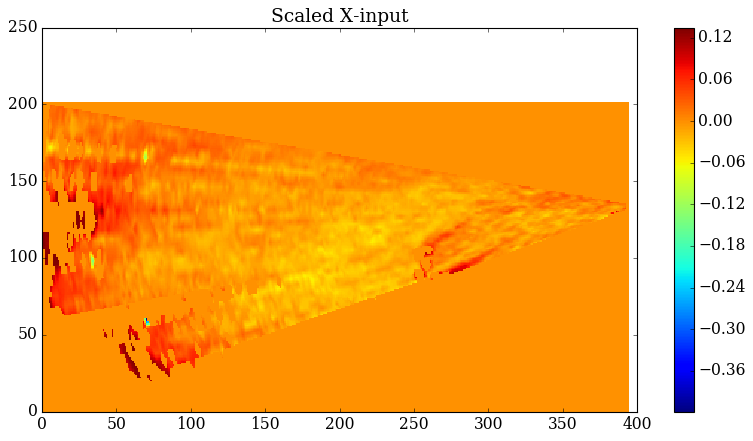

In [22]:
# Check first scan (radial speeds)
plt.pcolormesh(X_test_scaled.reshape(X_test_scaled.shape[0],201,394)[102])
plt.title('Scaled X-input')
plt.colorbar();

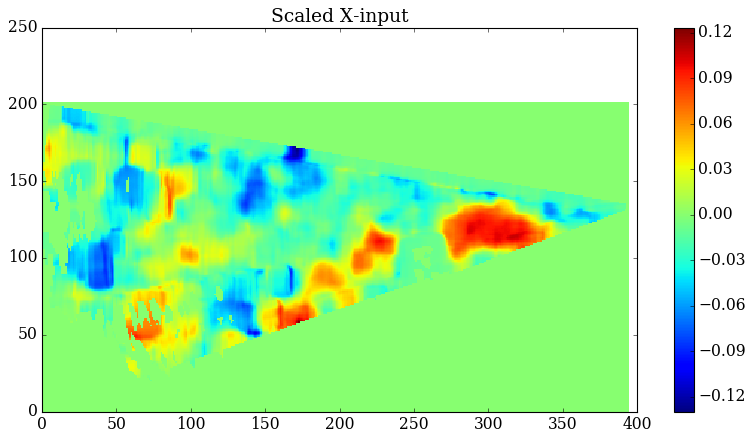

In [19]:
# Check one random scan (optical flows)
plt.pcolormesh(X_test_scaled[102,:,:,0])
plt.title('Scaled X-input')
plt.colorbar()

In [16]:
# Check mean and var (2D)

print(np.nanmean(X_train_scaled[:,:,:,0]))
print(np.nanvar(X_train_scaled[:,:,:,0]))
print(np.nanmean(X_test_scaled[:,:,:,0]))
print(np.nanvar(X_test_scaled[:,:,:,0]))
print(np.nanmean(X_train_scaled[:,:,:,1]))
print(np.nanvar(X_train_scaled[:,:,:,1]))
print(np.nanmean(X_test_scaled[:,:,:,1]))
print(np.nanvar(X_test_scaled[:,:,:,1]))

6.347050197720257e-17
0.0016934382903994458
-1.7217279005051034e-17
0.0007777838083009166
-7.507847175441797e-18
0.001418159041327287
-2.1462614987623206e-17
0.0018915910311487164


In [51]:
# Check mean and var (1D)

print(np.nanmean(X_train_scaled))
print(np.nanvar(X_train_scaled))
print(np.nanmean(X_test_scaled))
print(np.nanvar(X_test_scaled))

-3.0532056751754564e-16
0.0034457244214285603
4.570689665469156e-16
0.0011338277873070666


## Y-Scaling

In [23]:
# Use one scaler for each y_train/y_test
# Use scikit functions (in order to inverse transform later)

y_train_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
y_test_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

#y_train_scaler = preprocessing.RobustScaler()
#y_test_scaler = preprocessing.RobustScaler()

#y_train_scaler = preprocessing.StandardScaler()
#y_test_scaler = preprocessing.StandardScaler()

#y_train_scaled = np.empty_like(y_train)
#y_test_scaled = np.empty_like(y_test)

y_train_scaled = y_train_scaler.fit_transform(y_train)
y_test_scaled = y_test_scaler.fit_transform(y_test)

In [0]:
# Use separate scalers for both channels (apparently does the same thing)
# Use scikit functions (in order to inverse transform later)
y_train_u_scaler = preprocessing.RobustScaler()
y_train_v_scaler = preprocessing.RobustScaler()

y_test_u_scaler = preprocessing.RobustScaler()
y_test_v_scaler = preprocessing.RobustScaler()

y_train_scaled = np.empty_like(y_train)
y_test_scaled = np.empty_like(y_test)

y_train_scaled[:,0] = y_train_u_scaler.fit_transform(y_train[:,0].reshape(-1, 1)).flatten()
y_train_scaled[:,1] = y_train_v_scaler.fit_transform(y_train[:,1].reshape(-1, 1)).flatten()

y_test_scaled[:,0] = y_test_u_scaler.fit_transform(y_test[:,0].reshape(-1, 1)).flatten()
y_test_scaled[:,1] = y_test_v_scaler.fit_transform(y_test[:,1].reshape(-1, 1)).flatten()


In [47]:
# When y-data is 2-D data (time series of u & v)
y_train_scaled = np.empty_like(y_train)
y_test_scaled = np.empty_like(y_test)
# Standard scaling
#y[:,0] = (y_input_data[:,0] - np.nanmean(y_input_data[:,0], axis=None))/np.nanstd(y_input_data[:,0], axis=None)
#y[:,1] = (y_input_data[:,1] - np.nanmean(y_input_data[:,1], axis=None))/np.nanstd(y_input_data[:,1], axis=None)

# Mean subtraction / Range(max-min)
y_train_scaled[:,0] = (y_train[:,0] - np.nanmean(y_train[:,0], axis=None))/(np.nanmax(y_train[:,0], axis=None) - np.nanmin(y_train[:,0], axis=None))
y_train_scaled[:,1] = (y_train[:,1] - np.nanmean(y_train[:,1], axis=None))/(np.nanmax(y_train[:,1], axis=None) - np.nanmin(y_train[:,1], axis=None))

y_test_scaled[:,0] = (y_test[:,0] - np.nanmean(y_test[:,0], axis=None))/(np.nanmax(y_test[:,0], axis=None) - np.nanmin(y_test[:,0], axis=None))
y_test_scaled[:,1] = (y_test[:,1] - np.nanmean(y_test[:,1], axis=None))/(np.nanmax(y_test[:,1], axis=None) - np.nanmin(y_test[:,1], axis=None))

In [0]:
# When y-data is 1-D data (wind speed, active power, etc)
# Standard scaling
y = np.empty_like(y_input_data)
#y = (y_input_data - np.nanmean(y_input_data, axis=None))/np.nanstd(y_input_data, axis=None)
# Mean subtraction / Range(max-min)
y = (y_input_data - np.nanmean(y_input_data, axis=None))/(np.nanmax(y_input_data, axis=None) - np.nanmin(y_input_data, axis=None))

In [23]:
# Check the mean and variance (2D)

print(np.nanmean(y_train_scaled[:,0]))
print(np.nanvar(y_train_scaled[:,0]))
print(np.nanmean(y_train_scaled[:,1]))
print(np.nanvar(y_train_scaled[:,1]))
print(np.nanmean(y_test_scaled[:,0]))
print(np.nanvar(y_test_scaled[:,0]))
print(np.nanmean(y_test_scaled[:,1]))
print(np.nanvar(y_test_scaled[:,1]))

nan
nan
nan
nan
9.210739167260558e-17
0.00864729371656728
-4.605369583630279e-17
0.02894492350450648


/home/ellsim/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [24]:
#Fill NaNs (if they exist) with 0

y_train_scaled = np.nan_to_num(y_train_scaled)
y_test_scaled = np.nan_to_num(y_test_scaled)

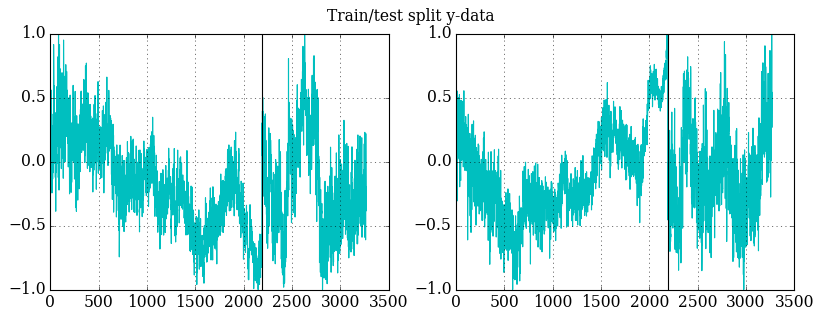

In [25]:
f = plt.figure(figsize=(12,4))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.plot(np.concatenate([y_train_scaled[:,0], y_test_scaled[:,0]]), c='c')
ax2.plot(np.concatenate([y_train_scaled[:,1], y_test_scaled[:,1]]), c='c')
ax.axvline(len(y_train_scaled), c='k')
ax2.axvline(len(y_train_scaled), c='k')
plt.suptitle('Train/test split y-data');

# Evaluation functions

In [26]:
# Automated plotting of predictions against y-test

def performance_scatter(y_test, y_test_ws, preds, preds_ws):
    f, axarr = plt.subplots(1,3, figsize=(14,4))
    #axarr[0].scatter(y_test[:], preds[:])
    axarr[0].scatter(y_test[:,0], preds[:,0])
    axarr[1].scatter(y_test[:,1], preds[:,1])
    axarr[2].scatter(y_test_ws, preds_ws)

    # Adds a line y=x to scatterplot 0
    lims = [
    np.min([axarr[0].get_xlim(), axarr[0].get_ylim()]),  # min of both axes
    np.max([axarr[0].get_xlim(), axarr[0].get_ylim()])]  # max of both axes 
    axarr[0].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    axarr[0].set_xlim(lims)
    axarr[0].set_ylim(lims)

    # Adds a line y=x to scatterplot 1
    lims = [
    np.min([axarr[1].get_xlim(), axarr[1].get_ylim()]),  # min of both axes
    np.max([axarr[1].get_xlim(), axarr[1].get_ylim()])]  # max of both axes 
    axarr[1].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    axarr[1].set_xlim(lims)
    axarr[1].set_ylim(lims)
    
    # Adds a line y=x to scatterplot 2
    lims = [
    np.min([axarr[2].get_xlim(), axarr[2].get_ylim()]),  # min of both axes
    np.max([axarr[2].get_xlim(), axarr[2].get_ylim()])]  # max of both axes 
    axarr[2].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    axarr[2].set_xlim(lims)
    axarr[2].set_ylim(lims)

    #axarr[0].set_xlim(0,3)
    #axarr[0].set_ylim(0,3)
    #axarr[1].set_xlim(0,3)
    #axarr[1].set_ylim(0,3)
    axarr[0].set_title('u-component', fontsize=12)
    axarr[1].set_title('v-component', fontsize=12)
    axarr[2].set_title('scalar wind speed', fontsize=12)

In [27]:
# Plot time series of predictions and reference

def performance_ts(y_test, y_test_ws, preds, preds_ws):
    f, axarr = plt.subplots(6,1, figsize=(14,12))
    f.subplots_adjust(hspace=1)
    
    axarr[0].plot(preds[:,0], c='r')
    axarr[1].plot(y_test[:,0], c='r')
    axarr[2].plot(preds[:,1], c='b')
    axarr[3].plot(y_test[:,1], c='b')
    axarr[4].plot(preds_ws, c='g')
    axarr[5].plot(y_test_ws, c='g')

    axarr[0].set_title('Prediction (var 0)')
    axarr[1].set_title('Reference (var 0)')
    axarr[2].set_title('Prediction (var 1)')
    axarr[3].set_title('Reference (var 1)')
    axarr[4].set_title('Prediction (scalar wind speed)')
    axarr[5].set_title('Reference (scalar wind speed)');

In [28]:
# Fit OLS linear model and print out table of results

def ols_fit_summary(x, y, single_var=False, var_num=0, add_const=True):
    if single_var == True:
        if add_const:
            result = sm.OLS(x,sm.add_constant(y)).fit()
        else:
            result = sm.OLS(x,y).fit()
    else:
        if add_const:
            result = sm.OLS(x[:,var_num],sm.add_constant(y[:,var_num])).fit()
        else:
            result = sm.OLS(x[:,var_num],y[:,var_num]).fit()
    return(result.summary())

def forcast_metrics(x, y, single_var=False, var_num=0):
    if single_var == True:
        mae = metrics.mean_absolute_error(x, y)
        mse = metrics.mean_squared_error(x, y)
        rmse = np.sqrt(metrics.mean_squared_error(x, y))
    else:
        mae = metrics.mean_absolute_error(x[:,var_num], y[:,var_num])
        mse = metrics.mean_squared_error(x[:,var_num], y[:,var_num])
        rmse = np.sqrt(metrics.mean_squared_error(x[:,var_num], y[:,var_num]))
    return(mae, mse, rmse)

## Conv2D

In [29]:
print(X_train_scaled.shape)
print(y_train_scaled.shape)

(2190, 201, 394, 1)
(2190, 2)


In [0]:
# Used for switching from ConvLSTM2D shape (remove timesteps)
X_train_scaled = np.squeeze(X_train_scaled)
X_test_scaled = np.squeeze(X_test_scaled)
y_train_scaled = np.squeeze(y_train_scaled)
y_test_scaled = np.squeeze(y_test_scaled)

In [55]:
# Modified from DJG's Swirlflow tutorial: 
# https://github.com/djgagne/swirlnet/blob/master/notebooks/deep_swirl_tutorial.ipynb

# Input data in shape (y, x, variables)
l2_a= 0.001
conv_net_in = Input(shape=X_train_scaled.shape[1:])
# First 2D convolution Layer
conv_net = Conv2D(16, (5, 5), padding="same", kernel_regularizer=l2(l2_a))(conv_net_in)
conv_net = Activation("relu")(conv_net)
#conv_net = BatchNormalization()(conv_net)
conv_net = Dropout(0.1)(conv_net)
# Average pooling takes the mean in a 2x2 neighborhood to reduce the image size
conv_net = AveragePooling2D()(conv_net)
# Second set of convolution and pooling layers
conv_net = Conv2D(32, (5, 5), padding="same", kernel_regularizer=l2(l2_a))(conv_net)
conv_net = Activation("relu")(conv_net)
#conv_net = BatchNormalization()(conv_net)
conv_net = Dropout(0.1)(conv_net)
conv_net = AveragePooling2D()(conv_net)
# Third set of convolution and pooling layers
conv_net = Conv2D(64, (5, 5), padding="same", kernel_regularizer=l2(l2_a))(conv_net)
conv_net = Activation("relu")(conv_net)
#conv_net = BatchNormalization()(conv_net)
conv_net = Dropout(0.1)(conv_net)
conv_net = AveragePooling2D()(conv_net)
# Flatten the last convolutional layer into a long feature vector
conv_net = Flatten()(conv_net)
# Add second input layer here?
#conv_net_in = Input(shape=y.shape[1:])
# Keras concat layers?
# Dense output layer
conv_net = Dense(2)(conv_net)
conv_model = Model(conv_net_in, conv_net)
# Use the Adam optimizer with default parameters
opt = Adam()
conv_model.compile(opt, loss='mean_squared_error')

In [56]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 201, 394, 1)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 201, 394, 16)      416       
_________________________________________________________________
activation_10 (Activation)   (None, 201, 394, 16)      0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 201, 394, 16)      0         
_________________________________________________________________
average_pooling2d_10 (Averag (None, 100, 197, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 100, 197, 32)      12832     
_________________________________________________________________
activation_11 (Activation)   (None, 100, 197, 32)      0         
__________

In [49]:
%%time
#early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1, min_delta=0.00001)

batch_size = 64
epochs = 100
model_hist = conv_model.fit(X_train_scaled, y_train_scaled,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_scaled, y_test_scaled)) #, callbacks=[early_stop])

Train on 2190 samples, validate on 1080 samples
Epoch 1/100
2190/2190 [==============================] - 8s 4ms/step - loss: 29.2578 - val_loss: 3.7799
Epoch 2/100
2190/2190 [==============================] - 8s 3ms/step - loss: 1.1099 - val_loss: 1.1991
Epoch 3/100
2190/2190 [==============================] - 8s 3ms/step - loss: 0.7207 - val_loss: 0.6620
Epoch 4/100
2190/2190 [==============================] - 7s 3ms/step - loss: 0.4822 - val_loss: 0.6567
Epoch 5/100
2190/2190 [==============================] - 7s 3ms/step - loss: 0.6590 - val_loss: 1.3616
Epoch 6/100
2190/2190 [==============================] - 7s 3ms/step - loss: 0.5819 - val_loss: 1.1137
Epoch 7/100
2190/2190 [==============================] - 7s 3ms/step - loss: 0.8054 - val_loss: 1.6052
Epoch 8/100
2190/2190 [==============================] - 7s 3ms/step - loss: 1.2312 - val_loss: 0.4909
Epoch 9/100
2190/2190 [==============================] - 7s 3ms/step - loss: 1.0354 - val_loss: 0.8003
Epoch 10/100
2190/2190 [

2190/2190 [==============================] - 7s 3ms/step - loss: 0.1792 - val_loss: 0.2836
Epoch 80/100
2190/2190 [==============================] - 7s 3ms/step - loss: 0.1202 - val_loss: 0.3003
Epoch 81/100
2190/2190 [==============================] - 7s 3ms/step - loss: 0.1106 - val_loss: 0.3095
Epoch 82/100
2190/2190 [==============================] - 7s 3ms/step - loss: 0.1048 - val_loss: 0.3254
Epoch 83/100
2190/2190 [==============================] - 8s 3ms/step - loss: 0.0931 - val_loss: 0.2796
Epoch 84/100
2190/2190 [==============================] - 7s 3ms/step - loss: 0.1054 - val_loss: 0.2940
Epoch 85/100
2190/2190 [==============================] - 8s 4ms/step - loss: 0.1119 - val_loss: 0.3888
Epoch 86/100
2190/2190 [==============================] - 8s 3ms/step - loss: 0.1280 - val_loss: 0.2976
Epoch 87/100
2190/2190 [==============================] - 7s 3ms/step - loss: 0.1180 - val_loss: 0.2670
Epoch 88/100
2190/2190 [==============================] - 8s 3ms/step - loss:

In [50]:
preds_scaled = conv_model.predict(X_test_scaled, batch_size=batch_size, verbose=1)
print(preds_scaled.shape)

1080/1080 [==============================] - 2s 2ms/step
(1080, 2)


In [51]:
preds = y_test_scaler.inverse_transform(preds_scaled)

In [0]:
np.save('cnn_updated_flows_preds.npy', preds)

In [0]:
save_model(conv_model, 'cnn_updated_flows_model.hdf')

In [52]:
# Get scalar wind speed for predictions
preds_ws = np.sqrt((preds[:,0])**2 + (preds[:,1])**2)

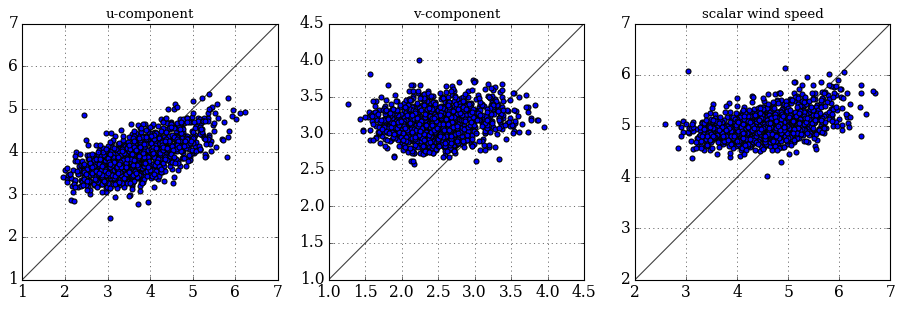

In [53]:
performance_scatter(y_test, y_test_ws, preds, preds_ws)

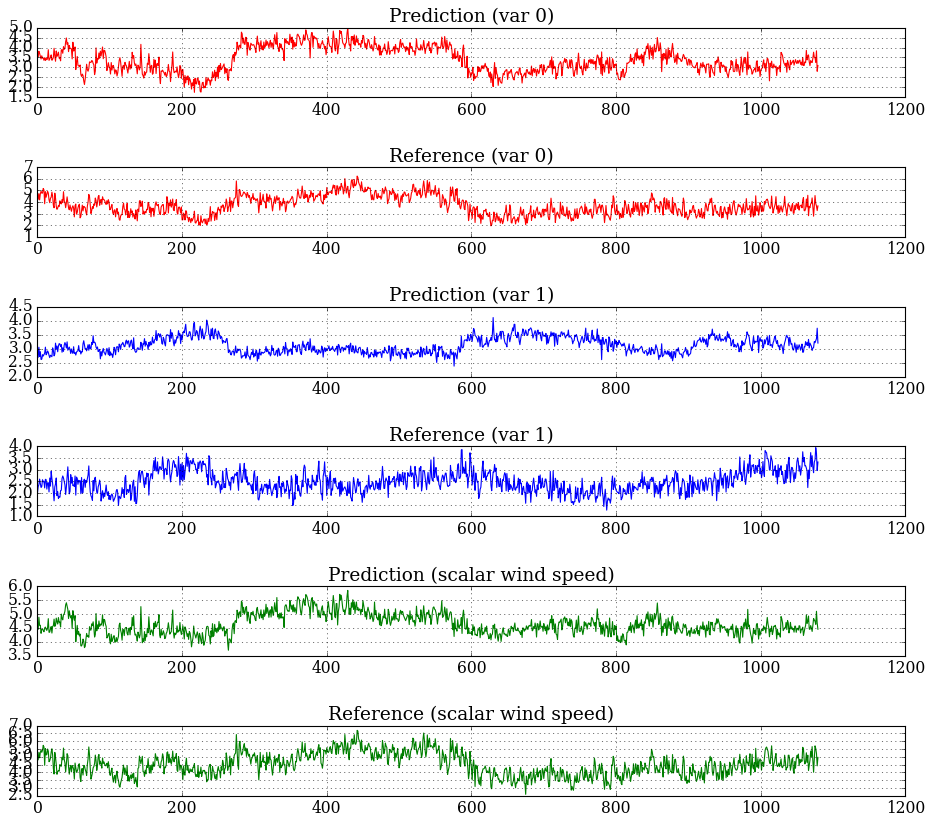

In [44]:
performance_ts(y_test, y_test_ws, preds, preds_ws)

In [45]:
print('VARIABLE 0: U COMPONENT')
print(ols_fit_summary(y_test, preds, var_num=0))
print('VARIABLE 1: V COMPONENT')
print(ols_fit_summary(y_test, preds, var_num=1))
print('SCALAR WIND SPEED')
print(ols_fit_summary(y_test_ws, preds_ws, single_var=True))

VARIABLE 0: U COMPONENT
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     1003.
Date:                Fri, 17 Aug 2018   Prob (F-statistic):          3.82e-156
Time:                        14:34:26   Log-Likelihood:                -956.15
No. Observations:                1080   AIC:                             1916.
Df Residuals:                    1078   BIC:                             1926.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6856      0

In [54]:
# Returned as: mae, mse, rmse
print('VARIABLE 0: U COMPONENT')
print(forcast_metrics(x=y_test, y=preds, var_num=0))
print('VARIABLE 1: V COMPONENT')
print(forcast_metrics(x=y_test, y=preds, var_num=1))
print('SCALAR WIND SPEED')
print(forcast_metrics(x=y_test_ws, y=preds_ws, single_var=True))

VARIABLE 0: U COMPONENT
(0.5232729630051202, 0.41145864478247757, 0.6414504227003655)
VARIABLE 1: V COMPONENT
(0.6989164070393661, 0.668390228732197, 0.8175513615254989)
SCALAR WIND SPEED
(0.6826428207268722, 0.6907705033062553, 0.8311260453783501)


# ConvLSTM2D (1 layer)

In [57]:
#X_train, X_test, y_train, y_test
print(X_train_scaled.shape)

(2190, 201, 394, 1)


In [0]:
# Find divisors with remainder 0
for i in range(1,50+1):
    if X.shape[0]%i == 0:
        print(i)

In [58]:
# Reshape X into timesteps
#Xx = np.reshape(X, (218, 15, 201, 394, 2))
#print(Xx.shape)

# Add a new axis with length 1 (timestep)
X_train_scaled = X_train_scaled[:, np.newaxis, :, :, :]
print(X_train_scaled.shape)
X_test_scaled = X_test_scaled[:, np.newaxis, :, :, :]
print(X_test_scaled.shape)

y_train_scaled = y_train_scaled[:, np.newaxis, :]
print(y_train_scaled.shape)
y_test_scaled = y_test_scaled[:, np.newaxis, :]
print(y_test_scaled.shape)

(2190, 1, 201, 394, 1)
(1080, 1, 201, 394, 1)
(2190, 1, 2)
(1080, 1, 2)


In [116]:
# Conv LSTM 2D

# Input data in shape (samples, timesteps, y, x, variables)

model_in = Input(shape=X_train_scaled.shape[1:])
opt = Adam()

# Only use 1 layer for now
# Average pooling on input?
model = ConvLSTM2D(32, (5, 5), return_sequences=True, activation='relu', padding='same')(model_in)
#print(keras.backend.shape(model))

model = Dropout(0.1)(model)
#model = MaxPooling3D(pool_size=(2,2,2))(model)
model = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(model)

# Shape output and compile
model = TimeDistributed(Flatten())(model)
# Dense layer = 2*timesteps
model = TimeDistributed(Dense(2))(model)
#model = Reshape((15,2), input_shape=(30,))(model)

model = Model(model_in, model)
model.compile(opt, loss='mean_squared_error')

In [117]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 1, 201, 394, 1)    0         
_________________________________________________________________
conv_lst_m2d_7 (ConvLSTM2D)  (None, 1, 201, 394, 32)   105728    
_________________________________________________________________
dropout_19 (Dropout)         (None, 1, 201, 394, 32)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 0, 100, 197, 32)   0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 0, 630400)         0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 0, 2)              1260802   
Total params: 1,366,530
Trainable params: 1,366,530
Non-trainable params: 0
_________________________________________________________________


In [61]:
print(X_train_scaled.shape)
print(y_train_scaled.shape)
print(X_test_scaled.shape)
print(y_test_scaled.shape)

(2190, 1, 201, 394, 1)
(2190, 1, 2)
(1080, 1, 201, 394, 1)
(1080, 1, 2)


In [118]:
batch_size = 64
epochs = 25
model_hist = model.fit(X_train_scaled, y_train_scaled,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_scaled, y_test_scaled))

ValueError: A target array with shape (2190, 1, 2) was passed for an output of shape (None, 0, 2) while using as loss `mean_squared_error`. This loss expects targets to have the same shape as the output.

In [110]:
preds_scaled = model.predict(X_test_scaled, batch_size=batch_size, verbose=1)

1080/1080 [==============================] - 4s 4ms/step


In [111]:
preds_scaled = preds_scaled.reshape((preds_scaled.shape[0], preds_scaled.shape[2]))
print(preds_scaled.shape)

(1080, 2)


In [112]:
preds = y_test_scaler.inverse_transform(preds_scaled)

In [113]:
# Get scalar wind speed for predictions
preds_ws = np.sqrt((preds[:,0])**2 + (preds[:,1])**2)

In [79]:
np.save('convlstm2d_rs_preds.npy', preds)

In [83]:
save_model(model, 'convlstm2d_rs_model.hdf')

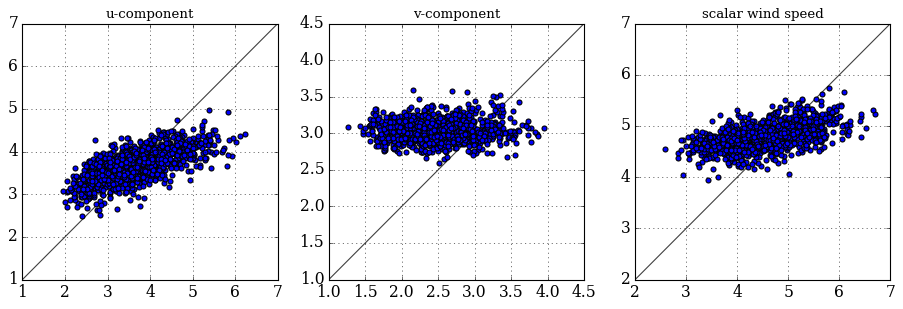

In [114]:
performance_scatter(y_test, y_test_ws, preds, preds_ws)

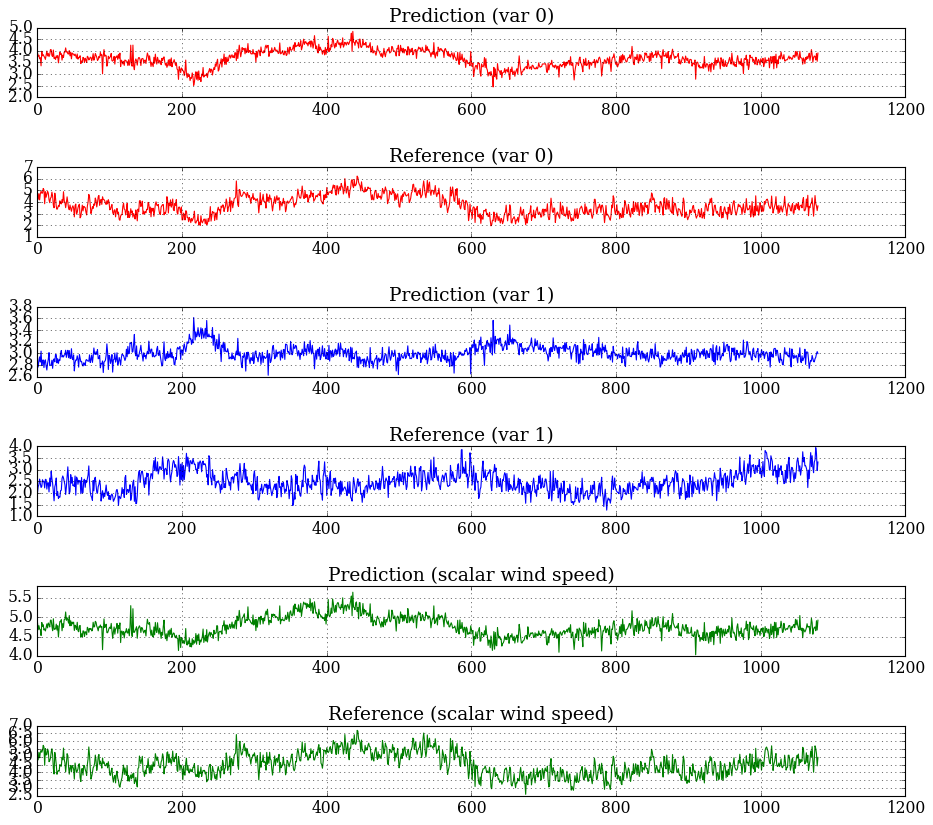

In [85]:
performance_ts(y_test, y_test_ws, preds, preds_ws)

In [86]:
print('VARIABLE 0: U COMPONENT')
print(ols_fit_summary(y_test, preds, var_num=0))
print('-' * 120)
print('VARIABLE 1: V COMPONENT')
print(ols_fit_summary(y_test, preds, var_num=1))
print('-' * 120)
print('SCALAR WIND SPEED')
print(ols_fit_summary(y_test_ws, preds_ws, single_var=True))

VARIABLE 0: U COMPONENT
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     1093.
Date:                Fri, 17 Aug 2018   Prob (F-statistic):          4.30e-166
Time:                        15:33:59   Log-Likelihood:                -933.23
No. Observations:                1080   AIC:                             1870.
Df Residuals:                    1078   BIC:                             1880.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0914      0

In [115]:
# Returned as: mae, mse, rmse
print('VARIABLE 0: U COMPONENT')
print(forcast_metrics(x=y_test, y=preds, var_num=0))
print('VARIABLE 1: V COMPONENT')
print(forcast_metrics(x=y_test, y=preds, var_num=1))
print('SCALAR WIND SPEED')
print(forcast_metrics(x=y_test_ws, y=preds_ws, single_var=True))

VARIABLE 0: U COMPONENT
(0.5023594248996905, 0.3856756411126158, 0.6210278907686964)
VARIABLE 1: V COMPONENT
(0.6158805209360009, 0.5247873381241469, 0.724422071809071)
SCALAR WIND SPEED
(0.5641970465806444, 0.47546258557337995, 0.6895379507854371)


# ConvLSTM2D (multi-layer)

In [88]:
print(X_train_scaled.shape)
print(y_train_scaled.shape)

(2190, 1, 201, 394, 1)
(2190, 1, 2)


In [89]:
# Conv LSTM 2D with multi-layers

# Input data in shape (samples, timesteps, y, x, channels (x and y optical flow motion))

model_in = Input(shape=X_train_scaled.shape[1:])
opt = Adam()

# 1st set of layers

model = ConvLSTM2D(16, (5, 5), return_sequences=True, activation='relu', padding='same', kernel_regularizer=l2(l2_a))(model_in)
model = Dropout(0.1)(model)
model = TimeDistributed(MaxPooling2D())(model)
#model = MaxPooling3D()(model)

# 2nd set of layers
model = ConvLSTM2D(32, (5, 5), return_sequences=True, activation='relu', padding='same', kernel_regularizer=l2(l2_a))(model)
model = Dropout(0.1)(model)
model = TimeDistributed(MaxPooling2D())(model)
#model = MaxPooling3D()(model)

# 3rd set of layers
model = ConvLSTM2D(64, (5, 5), return_sequences=True, activation='relu', padding='same', kernel_regularizer=l2(l2_a))(model)
model = Dropout(0.1)(model)
model = TimeDistributed(MaxPooling2D())(model)
#model = MaxPooling3D()(model)


# Shape output and compile
model = TimeDistributed(Flatten())(model)
model = TimeDistributed(Dense(2))(model)
#model = Reshape((15,2), input_shape=(30,))(model)

model = Model(model_in, model)
model.compile(opt, loss='mean_squared_error')

In [90]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1, 201, 394, 1)    0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 1, 201, 394, 16)   27264     
_________________________________________________________________
dropout_14 (Dropout)         (None, 1, 201, 394, 16)   0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 100, 197, 16)   0         
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 1, 100, 197, 32)   153728    
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 100, 197, 32)   0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 50, 98, 32)     0         
__________

In [91]:
batch_size = 64
epochs = 25
model_hist = model.fit(X_train_scaled, y_train_scaled,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_scaled, y_test_scaled))

Train on 2190 samples, validate on 1080 samples
Epoch 1/25
2190/2190 [==============================] - 40s 18ms/step - loss: 0.1489 - val_loss: 0.1221
Epoch 2/25
2190/2190 [==============================] - 35s 16ms/step - loss: 0.0587 - val_loss: 0.1235
Epoch 3/25
2190/2190 [==============================] - 35s 16ms/step - loss: 0.0437 - val_loss: 0.1501
Epoch 4/25
2190/2190 [==============================] - 35s 16ms/step - loss: 0.0380 - val_loss: 0.1921
Epoch 5/25
2190/2190 [==============================] - 35s 16ms/step - loss: 0.0343 - val_loss: 0.2575
Epoch 6/25
2190/2190 [==============================] - 35s 16ms/step - loss: 0.0339 - val_loss: 0.1699
Epoch 7/25
2190/2190 [==============================] - 35s 16ms/step - loss: 0.0325 - val_loss: 0.1888
Epoch 8/25
2190/2190 [==============================] - 35s 16ms/step - loss: 0.0306 - val_loss: 0.1963
Epoch 9/25
2190/2190 [==============================] - 35s 16ms/step - loss: 0.0302 - val_loss: 0.2237
Epoch 10/25
2190

In [93]:
preds_scaled = model.predict(X_test_scaled, batch_size=64, verbose=1)
print(preds_scaled.shape)

1080/1080 [==============================] - 5s 5ms/step


In [96]:
preds_scaled = preds_scaled.reshape((preds_scaled.shape[0], preds_scaled.shape[2]))
print(preds_scaled.shape)

(1080, 2)


In [97]:
preds = y_test_scaler.inverse_transform(preds_scaled)

In [99]:
# Get scalar wind speed for predictions
preds_ws = np.sqrt((preds[:,0])**2 + (preds[:,1])**2)

In [98]:
np.save('convlstm2d_multilayer_rs_preds.npy', preds)

In [100]:
save_model(model, 'convlstm2d_multilayer_rs_model.hdf')

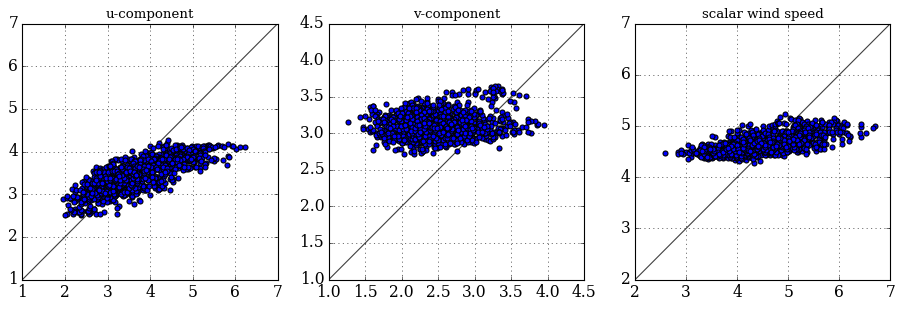

In [101]:
performance_scatter(y_test, y_test_ws, preds, preds_ws)

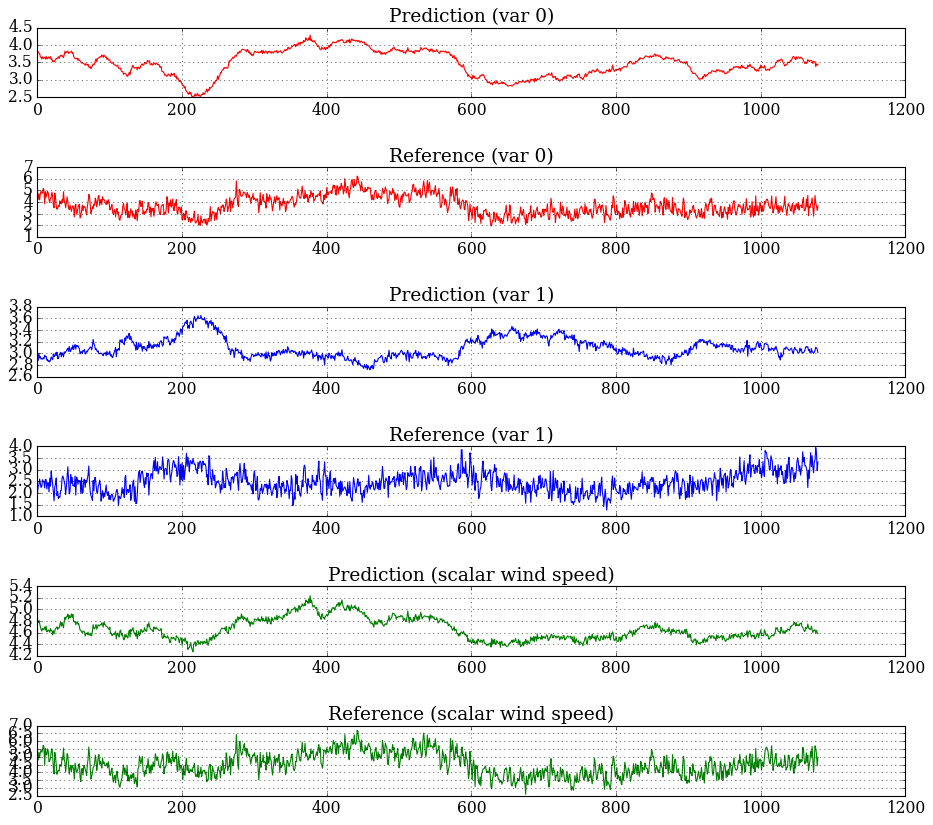

In [102]:
performance_ts(y_test, y_test_ws, preds, preds_ws)

In [103]:
print('VARIABLE 0: U COMPONENT')
print(ols_fit_summary(y_test, preds, var_num=0))
print('-' * 120)
print('VARIABLE 1: V COMPONENT')
print(ols_fit_summary(y_test, preds, var_num=1))
print('-' * 120)
print('SCALAR WIND SPEED')
print(ols_fit_summary(y_test_ws, preds_ws, single_var=True))

VARIABLE 0: U COMPONENT
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     1622.
Date:                Fri, 17 Aug 2018   Prob (F-statistic):          3.51e-217
Time:                        15:57:22   Log-Likelihood:                -815.46
No. Observations:                1080   AIC:                             1635.
Df Residuals:                    1078   BIC:                             1645.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1747      0

In [104]:
# Returned as: mae, mse, rmse
print('VARIABLE 0: U COMPONENT')
print(forcast_metrics(x=y_test, y=preds, var_num=0))
print('VARIABLE 1: V COMPONENT')
print(forcast_metrics(x=y_test, y=preds, var_num=1))
print('SCALAR WIND SPEED')
print(forcast_metrics(x=y_test_ws, y=preds_ws, single_var=True))

VARIABLE 0: U COMPONENT
(0.49503413502580357, 0.3943544837345653, 0.6279764993489527)
VARIABLE 1: V COMPONENT
(0.6518328890412641, 0.5839051319725184, 0.7641368542169121)
SCALAR WIND SPEED
(0.5357338747160095, 0.4218925367762743, 0.6495325525147099)


# CNN + LSTM layers

In [0]:
# Next try a combination of Conv2D and LSTM layers?

In [0]:
# Add another axis (here, 5th)
Xx = np.expand_dims(X, 4)

# All results comparison

In [0]:
# Load model predictions from saved files
# Model 1: Conv2D (multi layer set)
p1 =  np.load('cnn_10epoch_preds.npy')
# Model 2: ConvLSTM2D (single layer set)
p2 = np.load('convlstm2d_10epoch_preds.npy')
# Model 3: ConvLSTM2D (multi layer set)
p3 = np.load('convlstm2d_multilayer_10epoch_preds.npy')

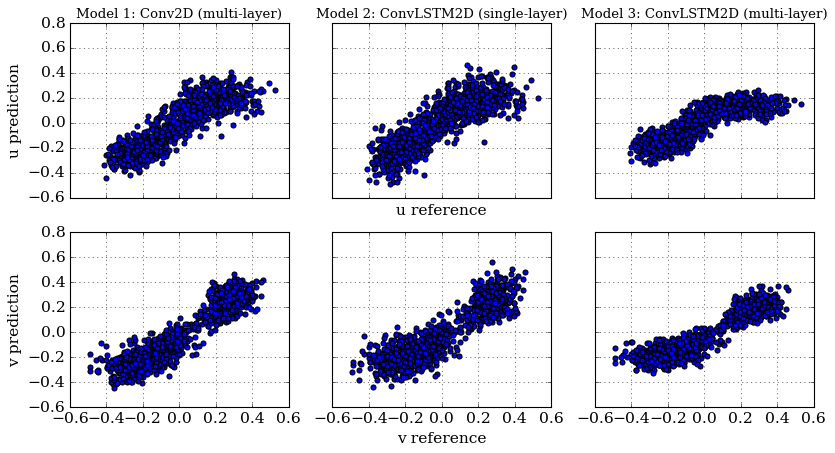

In [0]:
# Model comparison, with both variables together

f, axarr = plt.subplots(2,3, figsize=(12,6), sharex=True, sharey=True)
axarr[0][0].scatter(y_test[:,0], p1[:,0])
axarr[1][0].scatter(y_test[:,1], p1[:,1])
axarr[0][0].set_title('Model 1: Conv2D (multi-layer)', fontsize=12)

axarr[0][1].scatter(y_test[:,0], p2[:,0])
axarr[1][1].scatter(y_test[:,1], p2[:,1])
axarr[0][1].set_title('Model 2: ConvLSTM2D (single-layer)', fontsize=12)

axarr[0][2].scatter(y_test[:,0], p3[:,0])
axarr[1][2].scatter(y_test[:,1], p3[:,1])
axarr[0][2].set_title('Model 3: ConvLSTM2D (multi-layer)', fontsize=12)

axarr[0][1].set_xlabel('u reference')
axarr[1][1].set_xlabel('v reference')
axarr[0][0].set_ylabel('u prediction')
axarr[1][0].set_ylabel('v prediction')

plt.savefig('keras_model_comparison.png')

# Stateful prediction ahead (timesteps) 

In [0]:
# First check if y has any NaN values
# This would cause issues when shifting
np.isnan(y).any()

False

In [0]:
# Add new axis with lagged values
window_size = 100
# 100 = 21.6 mins

y[:,np.newaxis,:].shape

(3270, 1, 2)

In [0]:
print(y.shape)

(3270, 2)


In [0]:
# TTS needs to happen after new timestep dimensions
# Split up train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)

(1080, 2)

In [0]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2190, 201, 394, 2)
(1080, 201, 394, 2)
(2190, 2)
(1080, 2)
